In this notebook, we begin to work with the data that we scraped from arXiv and then preprocessed in `Scarping and Cleaning the Data.ipynb`. The ultimate goal is to predict the 3-character [MSC (Mathematical Subject Classification)](https://mathscinet.ams.org/mathscinet/msc/msc2020.html) classes for a preprint based on its cleaned title.<a name="cite_ref-a"></a>[<sup>*</sup>](#cite_note-a) This turns out to be a multi-label text classification task. 

$\hspace{3cm}$  `cleaned_title` $\mapsto$ 3-character MSC classes (e.g. 46L, 57M, 57R) $\hspace{1cm}$  (~140,000 data points and ~500 labels).
    


More precisely, here, we will:
1) explore and visualize the data;
2) encode the labels; 
3) split into the training and test sets via [stratified sampling for multi-label data](https://link.springer.com/chapter/10.1007/978-3-642-23808-6_10);
4) vectrozie the text data with [TF-IDF (Term Frequency-Inverse Document Frequency)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf);
5) train a simple support vector machine classifier. 

Based on the classifier above, models for predicting coarser target variables such as the 2-character MSC classes (*simplified* labels) or the primary arXiv category may be constructed.   

$\hspace{3cm}$  `cleaned_title` $\mapsto$ 3-character MSC classes (e.g. 46L, 57M, 57R) 
$\mapsto$ 2-character MSC classes (e.g. 46, 57) $\hspace{1cm}$  (~60 labels),

$\hspace{3cm}$  `cleaned_title` $\mapsto$ 3-character MSC classes $\mapsto$ the primary arXiv category (e.g. `math.AG`) $\hspace{1cm}$  (~30 labels).


<a name="cite_note-a"></a>[*](#cite_ref-a) Our data has other attributes as well, such as primary arXiv category, authors' names etc.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score, accuracy_score, jaccard_score

#stratified.py is imported (from the same folder) for multi-label stratified sampling. 
#The short python code is based on the iterstrat library.
from stratified import multilabel_train_test_split

from scipy import sparse

We first load the data. Among the columns, we only keep `primary_category`, `cleaned_title` and `MSC`.

In [2]:
raw_data=pd.read_csv('./data/data.csv',index_col=False)
raw_data=raw_data[['primary_category','cleaned_title','MSC']]

#While loading, the lists under the MSC column are loaded as strings. They should be turned back into lists.
raw_data['MSC']=raw_data['MSC'].apply(lambda x:eval(x))
raw_data.head()

,primary_category,cleaned_title,MSC
0,math.NA,quasi monoton robust local continu piecewis po...,"[65N, 41A]"
1,math.AT,higher structur ration homotopi theori,"[55S, 16S, 18M, 18G, 55R, 55P, 55Q]"
2,math.QA,indecompos involut solut yang baxt equat finit...,"[81R, 16T, 20E, 20N]"
3,math.QA,kashiwara vergn solut degre degre,"[57K, 17B]"
4,math.QA,tetrahedron equat quantum cluster algebra,"[81R, 82B, 13F]"


Starting data visualization: which primary categories have been most prevalent? 

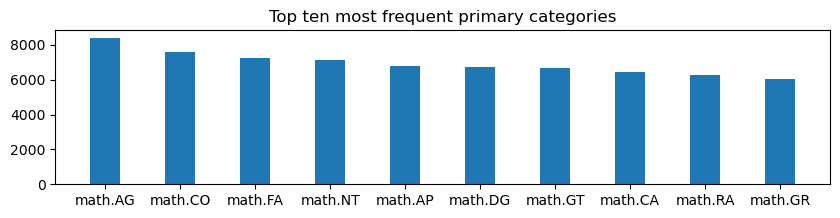

In [3]:
fig=plt.figure(figsize=(10,2))
ax=fig.add_subplot(1,1,1)

#Top 10 most frequent primary categories (bar chart)
ax.bar(x=raw_data['primary_category'].value_counts().head(10).index, 
        height=raw_data['primary_category'].value_counts().head(10),width=0.4)
ax.set_title('Top ten most frequent primary categories')

plt.show()

The labels (MSC classes) should be encoded. This results in the data frame `data`. In parallel, we create `data_simpl` for simplified (2-character MSC classes) encoded labels. As we go over the data to do encode the labels, we also form a dictionary of different words constituting the titles along with their multiplicities. 

In [4]:
#The lists of distinct labels and simplified labels that come up.
MSC_list=list(set.union(*raw_data['MSC'].apply(lambda x: set([y for y in x])).to_list()))
MSC_simpl_list=list(set.union(*raw_data['MSC'].apply(lambda x: set([y[:2] for y in x])).to_list()))

#Listing the numbers of labels and distinct lables across the data. 
num_labels=raw_data['MSC'].apply(lambda x: len(x)).to_list()
num_simpl_labels=raw_data['MSC'].apply(lambda x: len(set([y[:2] for y in x]))).to_list()

print(f'The number of distinct labels is {len(MSC_list)}.')
print(f"The average number of labels per entry is {round(sum(num_labels)/raw_data.shape[0],2)}.\n")

print(f'The number of distinct simplified labels is {len(MSC_simpl_list)}.')
print(f"The average number of simplified labels per entry is {round(sum(num_simpl_labels)/raw_data.shape[0],2)}.\n")


#We initialize a dictionary to record the multiplicities of various words that appear in cleaned titles. 
#We go over the data frame to update the dictionary, and to encode the labels. 
dict_words={} 

#Adding columns for encoded labels. 
data=pd.concat((raw_data,pd.DataFrame(data=0,index=np.arange(raw_data.shape[0]),
                             columns=MSC_list)),axis=1)
data_simpl=pd.concat((raw_data,pd.DataFrame(data=0,index=np.arange(raw_data.shape[0]),
                             columns=MSC_simpl_list)),axis=1)


for row in range(data.shape[0]):
    
    words=data['cleaned_title'][row].split(' ')      #The titles have been cleaned, no consecutive spaces.
    for word in words: 
        if word in dict_words.keys():
            dict_words[word]+=1
        else:
            dict_words[word]=1
                
    classes=data['MSC'][row]
    for MSC in classes:
        data.at[row,MSC]=1
    
    simpl_classes=list(set([x[:2] for x in classes]))
    for MSC in simpl_classes:
        data_simpl.at[row,MSC]=1
        

data.drop(columns=['MSC'],inplace=True)
data_simpl.drop(columns=['MSC'],inplace=True)


dict_MSC={}
for MSC in MSC_list:
    dict_MSC[MSC]=data[MSC].sum()

    
dict_MSC_simpl={}
for MSC in MSC_simpl_list:
    dict_MSC_simpl[MSC]=data_simpl[MSC].sum()

    
data.head()

The number of distinct labels is 532.
The average number of labels per entry is 2.37.

The number of distinct simplified labels is 63.
The average number of simplified labels per entry is 1.88.



,primary_category,cleaned_title,37D,92E,28E,62N,11G,55Q,74C,58E,...,28B,76H,34H,45M,44A,34E,30G,41A,35E,19C
0,math.NA,quasi monoton robust local continu piecewis po...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,math.AT,higher structur ration homotopi theori,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,math.QA,indecompos involut solut yang baxt equat finit...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,math.QA,kashiwara vergn solut degre degre,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,math.QA,tetrahedron equat quantum cluster algebra,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Visualizing the most common labels (MSC classes). 

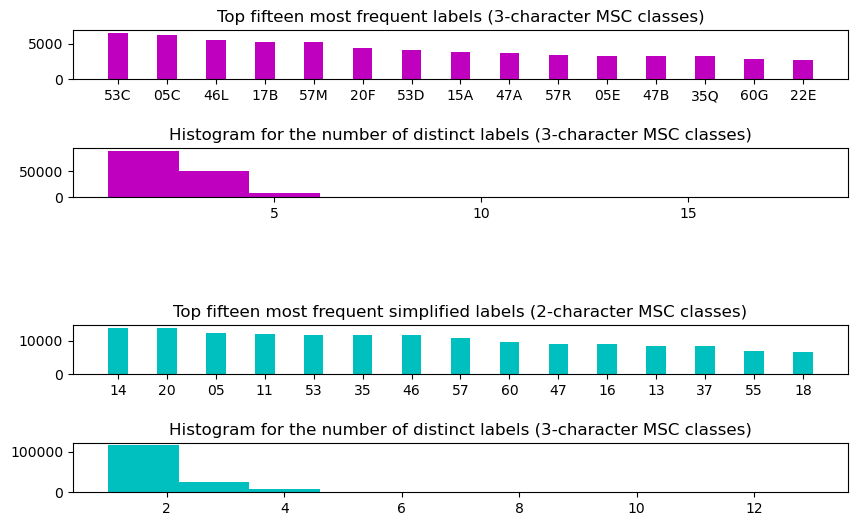

In [5]:
fig=plt.figure(figsize=(10,6))


#Top 10 most frequent MSC classes (bar chart)
ax1=fig.add_subplot(8,1,1)
top_index=np.argsort(-np.asarray(list(dict_MSC.values())))[0:15]
ax1.bar(x=np.asarray(list(dict_MSC.keys()))[top_index],
        height=np.asarray(list(dict_MSC.values()))[top_index],width=0.4,color='m')
ax1.set_title('Top fifteen most frequent labels (3-character MSC classes)')

#Number of labels (histogram)
ax2=fig.add_subplot(8,1,3)
ax2.hist(num_labels,color='m')
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of distinct labels (3-character MSC classes)')


#Top 10 most frequent 2-character MSC classes (bar chart)
ax3=fig.add_subplot(8,1,6)
top_index=np.argsort(-np.asarray(list(dict_MSC_simpl.values())))[0:15]
ax3.bar(x=np.asarray(list(dict_MSC_simpl.keys()))[top_index],
        height=np.asarray(list(dict_MSC_simpl.values()))[top_index],width=0.4,color='c')
ax3.set_title('Top fifteen most frequent simplified labels (2-character MSC classes)')


#Number of simplified labels (histogram)
ax2=fig.add_subplot(8,1,8)
ax2.hist(num_simpl_labels,color='c')
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of distinct labels (3-character MSC classes)')



plt.show()

If a label occurs only once throughout the data, then either the training or the test dataset will lack it. To avoid this, we drop all such labels along with instances whose only label is such a thing (if any).

In [6]:
MSC_only_once=[]
ascending=np.argsort(np.asarray(list(dict_MSC.values())))
for arg in ascending:
    if np.asarray(list(dict_MSC.values()))[arg]==1:
        MSC_only_once+=[np.asarray(list(dict_MSC.keys()))[arg]]
    else:
        break

print('MSC classes that happen only once are:', *MSC_only_once)

#Deleting these keys from the corresponding dictionary and list
for MSC in MSC_only_once:
    del dict_MSC[MSC]
    MSC_list.remove(MSC)

data.drop(columns=MSC_only_once,inplace=True)

if data[(data.iloc[:,2:]==0).all(axis=1)].shape[0]==0:
    print('\nNo need to drop any rows.')
else: 
    drop_index=data[(data.iloc[:,2:]==0).all(axis=1)].index
    data.drop(columns=MSC_only_once,inplace=True)
    print(f'\nThe number of rows dropped is {drop_index.shape[0]}')


#Saving the encoded data in a compressed form.     
data.to_csv('./data/data_encoded.csv',compression='zip',index=False)

MSC classes that happen only once are: 76K 83B

No need to drop any rows.


We next look at the cleaned titles (to be used as the input text data). How many words appear in them? Which words have been the most common?

The total number of words appearing in cleaned titles is 26222.

The average number of words per cleaned title is 6.48.


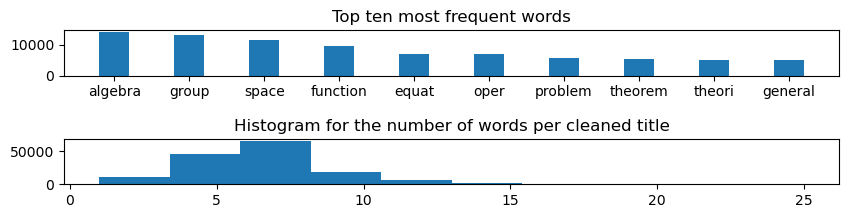

In [7]:
print(f'The total number of words appearing in cleaned titles is {len(dict_words)}.\n')

num_words=data['cleaned_title'].apply(lambda x:len(x.split(' ')))

print(f'The average number of words per cleaned title is {round(num_words.mean(),2)}.')

fig=plt.figure(figsize=(10,2))
ax1=fig.add_subplot(3,1,1)

#Top 10 most frequent primary categories (bar chart)
top_index=np.argsort(-np.asarray(list(dict_words.values())))[0:10]
ax1.bar(x=np.asarray(list(dict_words.keys()))[top_index],
        height=np.asarray(list(dict_words.values()))[top_index],width=0.4)
ax1.set_title('Top ten most frequent words')


ax2=fig.add_subplot(3,1,3)

#Number of constituent words (histogram)
ax2.hist(num_words)
ax2.locator_params(axis='x', integer=True)
ax2.set_title('Histogram for the number of words per cleaned title')

plt.show()

Stratified splitting of the data into training and test sets based on the [iterative-stratification](https://github.com/trent-b/iterative-stratification) library. We save the corresponding row indices for the future use. 

In [8]:
X_train, X_test, y_train, y_test = multilabel_train_test_split(data['cleaned_title'],
                                                               data.iloc[:,2:],stratify=data.iloc[:,2:], 
                                                               test_size=0.3, random_state=1)


train_index=np.asarray(X_train.index).tolist()
print(f'The number of training instances: {len(train_index)}')
with open('./data/train_index.json','w') as file:
    json.dump(train_index,file)

    
test_index=np.asarray(X_test.index).tolist()
print(f'The number of test instances: {len(test_index)}')
with open('./data/test_index.json','w') as file:
    json.dump(test_index,file)

The number of training instances: 104165
The number of test instances: 44699


Making sure no label is all zero in either the training or the test set. 

In [9]:
print(f'The number of all-zero columns in y_train is {np.sum((np.sum(y_train,axis=0)==0).astype(int))}.\n')

print(f'The number of all-zero columns in y_test is {np.sum((np.sum(y_test,axis=0)==0).astype(int))}.')

The number of all-zero columns in y_train is 0.

The number of all-zero columns in y_test is 0.


Are different labels (MSC classes) distributed proportionally between the training and test sets? Bar charts for the relative frequency of top MSC classes would tell us.

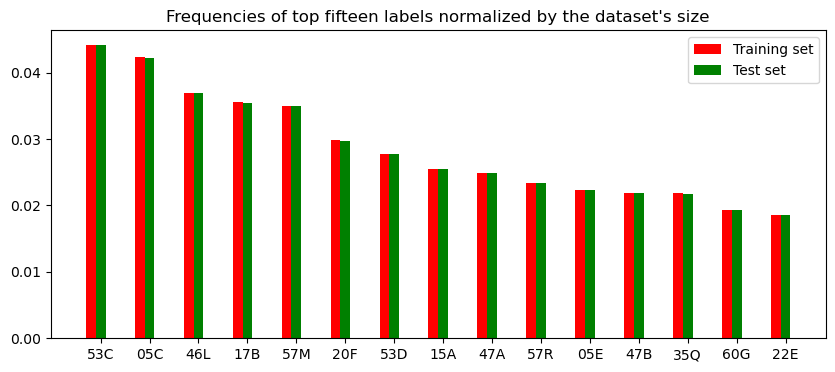

In [10]:
top_index=np.argsort(-np.asarray(list(dict_MSC.values())))[0:15]
top_MSC=np.asarray(list(dict_MSC.keys()))[top_index]


ind=np.arange(15)
width=0.2

fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
ax.bar(x=ind, height=y_train[top_MSC].sum(axis=0)/y_train.shape[0], width=width, color='r')
ax.bar(x=ind+width, height=y_test[top_MSC].sum(axis=0)/y_test.shape[0], width=width, color='g')
ax.set_xticks(ind+width)
ax.set_xticklabels(top_MSC)

ax.set_title("Frequencies of top fifteen labels normalized by the dataset's size")
ax.legend(('Training set','Test set'))

plt.show()

Next, we proceed with training a model for predicting MSC classes based on the text data under the column `cleaned_title`. First, the text data will be vectorized. 

In [11]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

print(f'The shapes of X_train and X_test (after encoding): {X_train.shape} and  {X_test.shape}\n')
print(f'The shapes of y_train and y_test: {y_train.shape} and  {y_test.shape}')

The shapes of X_train and X_test (after encoding): (104165, 285878) and  (44699, 285878)

The shapes of y_train and y_test: (104165, 530) and  (44699, 530)


Let's start with SVM classifier with linear kernel. We use scikit-learn's `OnevsRest` classifiers, which [supports](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) multilabel classification,  based on `LinearSVC`. `LinearSVC` is [much faster](https://stackoverflow.com/questions/35076586/when-should-one-use-linearsvc-or-svc) than `SVC` with linear kernel. We tune its hyperparameter `C` via cross-validation on the training set. The hyperparameter `C` [controls](https://stats.stackexchange.com/questions/31066/what-is-the-influence-of-c-in-svms-with-linear-kernel) the hyperplane's margin (larger `C` means larger cost for misclassification on the training set, and results in hyperplanes with smaller margins). 

In [12]:
for C in [0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000]:
    clf= OneVsRestClassifier(LinearSVC(penalty='l2',loss='squared_hinge',random_state=123,C=C),n_jobs=-1)
    scores=cross_val_score(clf,X_train,y_train,cv=3,n_jobs=-1,scoring='f1_weighted',)
    print(f"C={C}, the average cross-validation score={np.mean(scores)}")    

C=0.1, the average cross-validation score=0.08334932131470556
C=0.5, the average cross-validation score=0.19405717280068432
C=1, the average cross-validation score=0.23680484152897271
C=5, the average cross-validation score=0.2893918714315329
C=10, the average cross-validation score=0.29622879159170057
C=50, the average cross-validation score=0.3011609959759121
C=100, the average cross-validation score=0.3013255397266729
C=500, the average cross-validation score=0.3015895978637669
C=1000, the average cross-validation score=0.3013161344313699
C=5000, the average cross-validation score=0.30147390287885684
C=10000, the average cross-validation score=0.30152886018772457


The cross-validation score imporves very slightly beyond `C=50`. We choose this value for the hyperparameter, and we fit over the whole training set. We shall then evaluate various scikit-learn metrics including the variants of the `f1_score` and the `accuracy_score`. The latter only takes into account data instances for which all predicted labels match the true ones. On the other hand, the metrics `hamming_loss` and `jaccard_score` also detect cases where the predicted labels partially agree. But for our data, `hamming_loss` would not be very illuminating since most labels are zero (i.e. true negatives). Instead, we use the `jaccard_score` to capture the similarity of the predicted labels and true labels for a data point (which returns the ratio of true positives to the number of labels that are one or are predicted to be one or both.)

In [13]:
clf=OneVsRestClassifier(LinearSVC(random_state=123,C=50),n_jobs=-1)

clf.fit(X_train, y_train)


y_pred_train=clf.predict(X_train)
y_pred=clf.predict(X_test)


print('Metrics for predicting 3-character MSC classes based on the cleaned title:\n')
print(f' Train Accuracy: {round(100*accuracy_score(y_train, y_pred_train, normalize=True),2)}%')
print(f" Train F1-score macro: {round(100*f1_score(y_train, y_pred_train, average='macro'),2)}%")
print(f" Train F1-score micro: {round(100*f1_score(y_train, y_pred_train, average='micro'),2)}%")
print(f" Train F1-score weighted: {round(100*f1_score(y_train, y_pred_train, average='weighted'),2)}%")
print(f" Train Jaccard score: {round(100*jaccard_score(y_train, y_pred_train, average='weighted'),2)}")



print(f' \n Test Accuracy:  {round(100*accuracy_score(y_test, y_pred, normalize=True),2)}%')
print(f" Test F1-score macro: {round(100*f1_score(y_test, y_pred, average='macro'),2)}%")
print(f" Test F1-score micro: {round(100*f1_score(y_test, y_pred, average='micro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(y_test, y_pred, average='weighted'),2)}%") 
print(f" Test Jaccard score weighted: {round(100*jaccard_score(y_test, y_pred, average='weighted'),2)}") 

Metrics for predicting 3-character MSC classes based on the cleaned title:

 Train Accuracy: 99.8%
 Train F1-score macro: 99.94%
 Train F1-score micro: 99.93%
 Train F1-score weighted: 99.93%
 Train Jaccard score: 99.86
 
 Test Accuracy:  13.66%
 Test F1-score macro: 28.79%
 Test F1-score micro: 41.52%
 Test F1-score weighted: 40.4%
 Test Jaccard score weighted: 26.13


How has the classifier performed if we restrict to test instances with a fixed number of labels?

In [14]:
y_1=np.asarray(y_test)
y_2=y_pred

n_labels=1
list_n_labels=[]
list_accuracy=[]
list_jaccard=[]
list_f1=[]

while True:
    index_indicator=np.where(y_1.sum(axis=1)==n_labels)[0]
    if index_indicator.shape[0]==0:
        break
    list_n_labels+=[n_labels]
    
    list_accuracy+=[round(100*accuracy_score(y_1[index_indicator],y_2[index_indicator]),2)]
    
    #The zero_division=np.nan option: Among the rows of y_test that we have separated, some columns may be all 0. 
    list_f1+=[round(100*f1_score(y_1[index_indicator],y_2[index_indicator],average='weighted',zero_division=np.nan),2)]
    
    list_jaccard+=[round(100*jaccard_score(y_1[index_indicator],y_2[index_indicator],average='weighted',zero_division=0),2)]
    
    #The average number of incorrectly predicted labels
    n_labels+=1
    
print(f'Accuracy socres as the number of labels increases: {list_accuracy}.')
print(f'Weighted f1-scores as the number of labels increases: {list_f1}.')
print(f'Weighted Jaccard scores as the number of labels increases: {list_jaccard}.')

Accuracy socres as the number of labels increases: [29.88, 11.19, 4.57, 3.03, 2.2, 1.77, 1.96, 0.0, 3.33, 0.0, 8.33, 0.0, 0.0, 0.0].
Weighted f1-scores as the number of labels increases: [48.68, 45.44, 39.93, 37.39, 35.91, 35.91, 40.46, 56.83, 72.15, 65.97, 75.56, 85.56, nan, 100.0].
Weighted Jaccard scores as the number of labels increases: [33.17, 29.78, 25.19, 23.0, 21.07, 19.09, 17.27, 17.58, 17.96, 16.05, 14.9, 32.64, 0.0, 7.14].


We observe that the accuracy score (for which rows of `y_test` and `y_pred` should exactly match) becomes poorer. One the other hand, the weighted $F_1$ and Jaccard scores are much more reasonable. 

Now based on `clf`, we construct another classfier `clf_simplified` for predicting simplified labels.

In [15]:
#A binary matrix that captures the relation between 3-character and 2-character (truncated) MSC classes.
T=np.zeros([len(MSC_list),len(MSC_simpl_list)])

for i in range(len(MSC_list)):
    for j in range(len(MSC_simpl_list)):
        if MSC_list[i][:2]==MSC_simpl_list[j]:
            T[i][j]=1
            
class clf_reduction:
    '''
    Composing with a linear transformation to obtain binary outputs in a smaller space.
    '''
    def __init__(self, clf, T):
        self.clf=clf
        self.transformation=T
    def predict(self,X):
        return (np.matmul(self.clf.predict(X),T)>0).astype(int) 
    
clf_simplified=clf_reduction(clf,T)
y_pred_simplified=clf_simplified.predict(X_test)

print('Metrics for predicting 2-character MSC classes based on the cleaned title:\n')
print(f' Test Accuracy:  {round(100*accuracy_score(data_simpl.iloc[test_index,2:], y_pred_simplified, normalize=True),2)}%')
print(f" Test F1-score macro: {round(100*f1_score(data_simpl.iloc[test_index,2:], y_pred_simplified, average='macro'),2)}%")
print(f" Test F1-score micro: {round(100*f1_score(data_simpl.iloc[test_index,2:], y_pred_simplified, average='micro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(data_simpl.iloc[test_index,2:], y_pred_simplified, average='weighted'),2)}%") 
print(f" Test Jaccard score weighted: {round(100*jaccard_score(data_simpl.iloc[test_index,2:], y_pred_simplified, average='weighted'),2)}%") 

Metrics for predicting 2-character MSC classes based on the cleaned title:

 Test Accuracy:  26.8%
 Test F1-score macro: 44.56%
 Test F1-score micro: 53.98%
 Test F1-score weighted: 53.45%
 Test Jaccard score weighted: 37.02%


There have been machine learning projects, such as the [arXiv Classifier](https://github.com/arXiv/arxiv-classifier/), aimed at predicting a preprint's primary arXiv category. Our classifier `clf` predicts MSC classes which are intuitively finer (there are often multiple MSC classes for each math subject). But the primary category can be predicted based on MSC classes with a reasonable accuracy. Thus we can combine such a classifier with `clf` to obtain a model `clf_arXiv_primary` for detecting the primary arXiv category based on the cleaned title.  

In [16]:
X_train_CatPred=sparse.csr_matrix(data.iloc[train_index,2:])
y_train_CatPred=data.iloc[train_index,:]['primary_category']

X_test_CatPred=sparse.csr_matrix(data.iloc[test_index,2:])
y_test_CatPred=data.iloc[test_index,:]['primary_category']


clf_CatPred=OneVsRestClassifier(RandomForestClassifier(n_estimators=30, bootstrap=True, max_features=0.7,
                                                       random_state=999),n_jobs=-1)
clf_CatPred.fit(X_train_CatPred,y_train_CatPred)

y_pred_train_CatPred=clf_CatPred.predict(X_train_CatPred)
y_pred_CatPred=clf_CatPred.predict(X_test_CatPred)

print('Metrics for predicting the primary arXiv category based on MSC classes:\n')
print(f' Train Accuracy: {round(100*accuracy_score(y_train_CatPred, y_pred_train_CatPred, normalize=True),2)}%')
print(f" Train F1-score macro: {round(100*f1_score(y_train_CatPred, y_pred_train_CatPred, average='macro'),2)}%")
print(f" Train F1-score micro: {round(100*f1_score(y_train_CatPred, y_pred_train_CatPred, average='micro'),2)}%")
print(f" Train F1-score weighted: {round(100*f1_score(y_train_CatPred, y_pred_train_CatPred, average='weighted'),2)}%")



print(f' \n Test Accuracy:  {round(100*accuracy_score(y_test_CatPred, y_pred_CatPred, normalize=True),2)}%')
print(f" Test F1-score macro: {round(100*f1_score(y_test_CatPred, y_pred_CatPred, average='macro'),2)}%")
print(f" Test F1-score micro: {round(100*f1_score(y_test_CatPred, y_pred_CatPred, average='micro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(y_test_CatPred, y_pred_CatPred, average='weighted'),2)}%")

Metrics for predicting the primary arXiv category based on MSC classes:

 Train Accuracy: 82.65%
 Train F1-score macro: 68.74%
 Train F1-score micro: 82.65%
 Train F1-score weighted: 82.39%
 
 Test Accuracy:  66.06%
 Test F1-score macro: 22.21%
 Test F1-score micro: 66.06%
 Test F1-score weighted: 65.37%


In [17]:
class clf_composed:
    '''
    Composing two fitted classifiers with predict method.
    '''
    def __init__(self, clf_MSC,clf_category_from_MSC):
        self.clf_1=clf_MSC
        self.clf_2=clf_category_from_MSC
        
    def predict(self,X):
        return self.clf_2.predict(self.clf_1.predict(X))

clf_arXiv_primary=clf_composed(clf,clf_CatPred)
y_pred_arXivCat=clf_arXiv_primary.predict(X_test)

print('Metrics for predicting the primary arXiv category based on the cleaned title:\n')
print(f' Test Accuracy:  {round(100*accuracy_score(y_test_CatPred, y_pred_arXivCat, normalize=True),2)}%')
print(f" Test F1-score macro: {round(100*f1_score(y_test_CatPred, y_pred_arXivCat, average='macro'),2)}%")
print(f" Test F1-score micro: {round(100*f1_score(y_test_CatPred, y_pred_arXivCat, average='micro'),2)}%")
print(f" Test F1-score weighted: {round(100*f1_score(y_test_CatPred, y_pred_arXivCat, average='weighted'),2)}%")

Metrics for predicting the primary arXiv category based on the cleaned title:

 Test Accuracy:  46.76%
 Test F1-score macro: 15.76%
 Test F1-score micro: 46.76%
 Test F1-score weighted: 50.96%


**Conclusion)** Three-character MSC classes are much finer target variables. Indeed, the classification metrics improve when one tries to obtain two-character MSC classes or the primary arXiv category based on the predicted three-character MSC classes.  

https://towardsdatascience.com/multi-label-classification-using-bag-of-words-bow-and-tf-idf-4f95858740e5 (BoW and Tf-idf with sparse vectors, toxic comments dataset)

https://medium.com/analytics-vidhya/an-introduction-to-multi-label-text-classification-b1bcb7c7364c (Discusses Classifier Chain, uses the Kaggle research topics dataset)

https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff (Various techniques, OnevsRest, Binary Relevance etc, toxic comment dataset)

**************************************************************

NLP Zero to Hero (IMDB sentiment analysis)

https://medium.com/@prateekgaurav/nlp-zero-to-hero-part-1-introduction-bow-tf-idf-word2vec-c1b11ed77a2
https://medium.com/@prateekgaurav/nlp-zero-to-hero-part-2-vanilla-rnn-lstm-gru-bi-directional-lstm-77fd60fc0b44
https://medium.com/@prateekgaurav/nlp-zero-to-hero-part-3-transformer-based-models-conclusion-8191186301a9


*****************************************************************

Much more relevant, problems with many labels

https://www.kdnuggets.com/2023/03/multilabel-nlp-analysis-class-imbalance-loss-function-approaches.html

https://keras.io/examples/nlp/multi_label_classification/

(Hugging Face: https://discuss.huggingface.co/t/most-efficient-multi-label-classifier/9296)

******************************************************************

Multioutput 
https://www.kdnuggets.com/2023/08/multilabel-classification-introduction-python-scikitlearn.html

Multioutput vs OnevsRest for Multilabel classification
https://stackoverflow.com/questions/42819460/what-is-the-difference-between-onevsrestclassifier-and-multioutputclassifier-in


******************************************************************

 https://stackoverflow.com/questions/54402210/how-to-enable-probability-estimates-when-using-scikitlearns-linearsvc-classifie. https://stats.stackexchange.com/questions/263393/scikit-correct-way-to-calibrate-classifiers-with-calibratedclassifiercv